* Use the face detection model MobileNet SSD v2 (face) - no labels required

In [1]:
import argparse
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import tflite_runtime.interpreter as tflite

In [2]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [3]:
all_models = os.listdir(all_models_dir)

In [4]:
for filename in all_models:
    if 'ssd_v2' in filename:
        print(filename)

mobilenet_ssd_v2_face_quant_postprocess.tflite
mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess.tflite


In [5]:
image = 'images/' + 'face.jpg'
# image = all_models_dir + 'parrot.jpg'
image

'images/face.jpg'

In [6]:
model_file = all_models_dir + 'mobilenet_ssd_v2_face_quant_postprocess.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_ssd_v2_face_quant_postprocess.tflite'

In [7]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [8]:
input_details

[{'name': 'normalized_input_image_tensor',
  'index': 306,
  'shape': array([  1, 320, 320,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128)}]

In [9]:
input_details[0]['index']

306

In [11]:
floating_model = input_details[0]['dtype'] == np.float32
floating_model

False

In [26]:
output_details

[{'name': 'TFLite_Detection_PostProcess',
  'index': 298,
  'shape': array([ 1, 50,  4]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:1',
  'index': 299,
  'shape': array([ 1, 50]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:2',
  'index': 300,
  'shape': array([ 1, 50]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'TFLite_Detection_PostProcess:3',
  'index': 301,
  'shape': array([1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [12]:
# NxHxWxC, H:1, W:2. Note this is not maintaining aspect ratio
height = input_details[0]['shape'][1]
print(height)
width = input_details[0]['shape'][2]
print(width)
img = Image.open(image).resize((width, height))

320
320


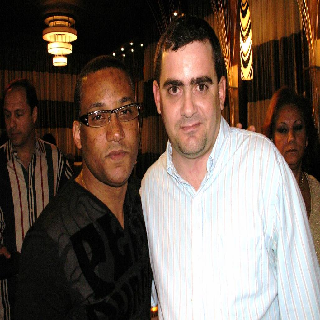

In [13]:
img

In [14]:
# add N dim
input_data = np.expand_dims(img, axis=0)

In [15]:
input_data.shape

(1, 320, 320, 3)

In [16]:
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std

In [21]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = np.squeeze(interpreter.get_tensor(output_details[0]['index'])) # squeeze dims
# output_data = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 377 ms, sys: 0 ns, total: 377 ms
Wall time: 391 ms


In [22]:
output_data.shape

(50, 4)

In [23]:
output_data

array([[6.9132969e-02, 4.0972465e-01, 4.9776006e-01, 7.7808756e-01],
       [1.5155402e-01, 1.3498394e-01, 6.1326098e-01, 5.3177571e-01],
       [3.0172244e-01, 8.1183499e-01, 5.2549791e-01, 9.9993783e-01],
       [2.6126793e-01, 1.6906776e-03, 4.5778909e-01, 1.5318279e-01],
       [2.4652562e-01, 9.6176869e-01, 4.0925643e-01, 9.9753159e-01],
       [1.8987106e-01, 9.2936885e-01, 4.8001862e-01, 1.0102365e+00],
       [9.9960238e-02, 3.1019932e-01, 6.1010021e-01, 5.5858856e-01],
       [2.9710248e-01, 9.5779568e-01, 4.5983329e-01, 9.9940938e-01],
       [2.2413864e+31, 3.5356109e+32, 3.5356109e+32, 3.5356109e+32],
       [1.4041426e+33, 5.5761635e+33, 5.5763213e+33, 2.2143026e+34],
       [1.3860403e+36, 5.5764792e+33, 2.2148077e+34, 5.5763213e+33],
       [8.9029031e+31, 3.5357096e+32, 3.5357096e+32, 3.5357096e+32],
       [3.5357096e+32, 1.4041821e+33, 1.4041426e+33, 8.9029031e+31],
       [5.5761635e+33, 3.5354136e+32, 5.6435426e+30, 3.5357096e+32],
       [8.9021632e+31, 2.2414481e+

What to do with this output? Need to flatten?

In [24]:
results = output_data.flatten()
print(results.shape)
results

(200,)


array([6.9132969e-02, 4.0972465e-01, 4.9776006e-01, 7.7808756e-01,
       1.5155402e-01, 1.3498394e-01, 6.1326098e-01, 5.3177571e-01,
       3.0172244e-01, 8.1183499e-01, 5.2549791e-01, 9.9993783e-01,
       2.6126793e-01, 1.6906776e-03, 4.5778909e-01, 1.5318279e-01,
       2.4652562e-01, 9.6176869e-01, 4.0925643e-01, 9.9753159e-01,
       1.8987106e-01, 9.2936885e-01, 4.8001862e-01, 1.0102365e+00,
       9.9960238e-02, 3.1019932e-01, 6.1010021e-01, 5.5858856e-01,
       2.9710248e-01, 9.5779568e-01, 4.5983329e-01, 9.9940938e-01,
       2.2413864e+31, 3.5356109e+32, 3.5356109e+32, 3.5356109e+32,
       1.4041426e+33, 5.5761635e+33, 5.5763213e+33, 2.2143026e+34,
       1.3860403e+36, 5.5764792e+33, 2.2148077e+34, 5.5763213e+33,
       8.9029031e+31, 3.5357096e+32, 3.5357096e+32, 3.5357096e+32,
       3.5357096e+32, 1.4041821e+33, 1.4041426e+33, 8.9029031e+31,
       5.5761635e+33, 3.5354136e+32, 5.6435426e+30, 3.5357096e+32,
       8.9021632e+31, 2.2414481e+31, 2.2255408e+31, 5.6430802e

Get the index of the top results